In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

n = 10
c = 3e8
T_tx = 10  # da regolare
r_max = 60e9  # Marte
tau_max = 130

In [2]:
### Generates a random network of n nodes (the first one corresponds to earth)
### r = max distance

def generate_network(n,r_max,seed=100,polar = False):
    
    np.random.seed(seed)
    nodes = np.zeros((n,3))
    
    r = np.random.rand(n,1)*r_max
    r[0] = 0 #Earth
    theta = np.random.rand(n,1)*4*np.pi - 2*np.pi
    phi = np.random.rand(n,1)*4*np.pi - 2*np.pi
    
    if polar==True:
        return np.hstack((r,theta,phi))  #polar coordinates
    
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)

    
    return np.hstack((x,y,z))   #cartesian coordinates

In [3]:
### Creates the weighted adjacency matrix of the network
### Entries represent propagation times between nodes

def adjacency_matrix(nodes):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            A[i,j] = A[j,i] = np.linalg.norm(nodes[i,:]-nodes[j,:]) / c
    A[A>=tau_max] = np.inf   #sets to infinity weight of links with tau > tau_max
    return A

In [4]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth

#test
print(nodes.shape)
print(A.shape)
print("sorted_nodes: {}".format(sorted_nodes))

(10, 3)
(10, 10)
sorted_nodes: [0 4 5 8 1 2 9 3 6 7]


In [5]:
def plot_network(nodes):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(nodes[1:,0],nodes[1:,1],nodes[1:,2])
    ax.scatter(nodes[0,0],nodes[0,1],nodes[0,2],color="red",s=100)   #Earth
    plt.show()

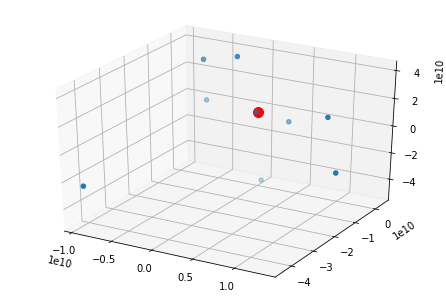

In [6]:
plot_network(nodes)

In [7]:
## disable some links for a certain amount of time
##
## modes:
## light mode: few links, short time
## heavy mode: few links, long time
## unstable mode: many links, short time
## extreme mode: many links, long time
##
## priority: random, near, far
## prioritize disabling of links involving nodes near or far from Earth
## 
## custom_n_targets = number of targets
## custom_offtimes: array containing possible values for off times expressed in number of updates of A

def disable_links(A,n_updates, mode="light",priority="random", custom_n_targets = None, custom_offtimes = None):

    arrays = [A for i in range(n_updates)]
    At = np.stack(arrays,axis=2)      #adds temporal dimension
    
    t_nodes = np.arange(n)
    
    if priority == "random": np.random.shuffle(t_nodes)   #nodes targeted for link removal
    elif priority == "near": t_nodes = sorted_nodes[:int(np.ceil(n/3))]
    elif priority == "far": t_nodes = np.flip(sorted_nodes)[:int(np.ceil(n/3))]
    
    possible_links = []
    possible_links = np.array([[x,y] for x in t_nodes for y in range(n) if x!=y if A[x,y]<tau_max if [y,x] not in possible_links])

    if mode == "light":  
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//40]   # selected links stay off for around 1/10 of the total time
            
    if mode == "heavy":
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//3]
        
    if mode == "unstable":
        n_targets = possible_links.shape[0]*3//4
        offtimes = [n_updates//10]
        
    if mode == "extreme":
        n_targets = possible_links.shape[0]*3//4
        offtimes = [n_updates//3]
        
    if custom_n_targets != None: n_targets = custom_n
    if custom_offtimes != None: offtimes = custom_offtimes
 
    disabled_links = np.random.permutation(possible_links)[:n_targets,:]
    
    for link in disabled_links:
        print(link)
        start = np.random.randint(0,n_updates)
        print("start {}".format(start))
        end = start + np.random.choice(offtimes)
        print("end {}".format(end))
        for t in range(start,min(n_updates,end)):
            At[link[0],link[1],t] = At[link[1],link[0],t] = np.inf
            
    return At

[5 9]
start 0
end 10
[6 1]
start 55
end 65
[1 8]
start 98
end 108
[5 0]
start 19
end 29
[5 2]
start 53
end 63
[3 2]
start 68
end 78
[8 0]
start 62
end 72
[0 2]
start 50
end 60
[8 5]
start 68
end 78
[4 8]
start 35
end 45
[0 5]
start 23
end 33
[9 0]
start 9
end 19
[1 9]
start 48
end 58
[8 1]
start 21
end 31
[2 0]
start 25
end 35
[9 5]
start 54
end 64
[8 4]
start 6
end 16
[2 5]
start 37
end 47
[4 2]
start 58
end 68
[2 3]
start 39
end 49
[1 0]
start 94
end 104
[0 8]
start 51
end 61
[0 4]
start 30
end 40
[1 5]
start 66
end 76
[4 1]
start 24
end 34
[0 1]
start 55
end 65
[1 4]
start 17
end 27
[9 6]
start 45
end 55
[9 1]
start 89
end 99
[5 8]
start 45
end 55
[2 7]
start 35
end 45
[0 9]
start 16
end 26
[5 1]
start 12
end 22
[7 2]
start 86
end 96


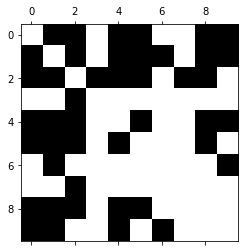

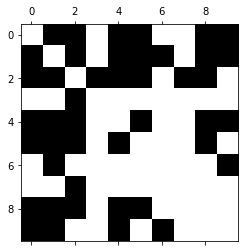

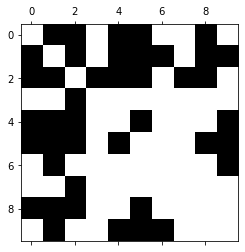

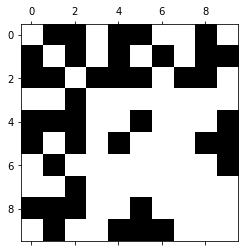

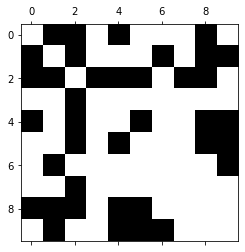

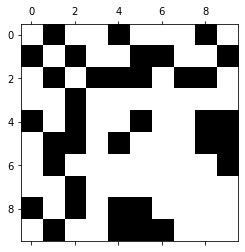

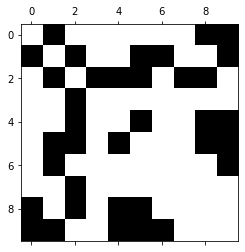

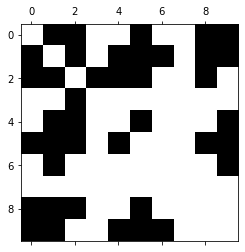

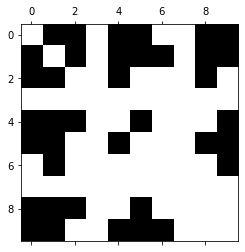

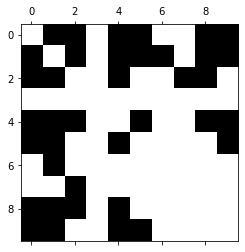

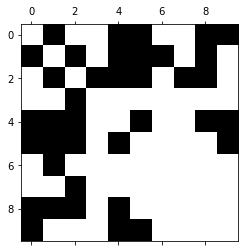

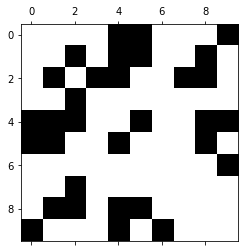

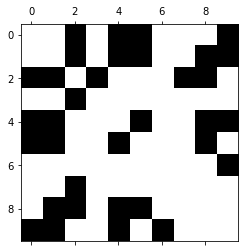

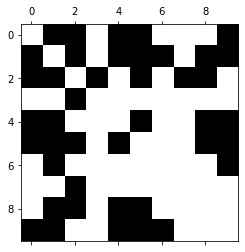

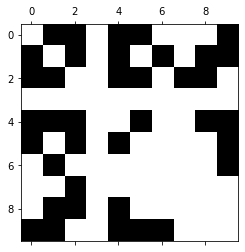

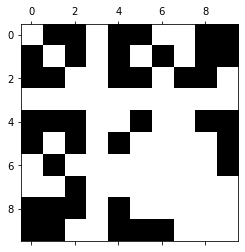

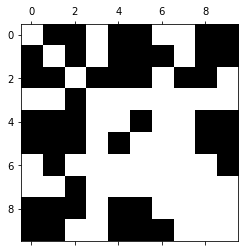

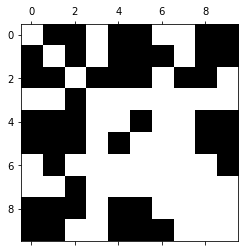

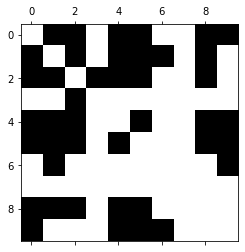

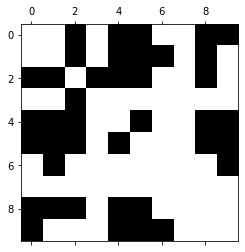

In [8]:
### TEST DISABLE LINKS
### SORTED NODES = [0 4 5 8 1 2 9 3 6 7]

test = True
if(test):
    At = disable_links(A,100,mode="unstable")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()